In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from typing import Union

H, W, f = 400, 400, 1200
rays_o = np.zeros((H*W,3))
rays_d = np.zeros((H*W,3))
u = np.arange(H)
v = np.arange(W)
print(u.shape, v.shape)
u,v = np.meshgrid(u,v)
print(u[:5,:5])
print(v[:5,:5])
print(u.shape,v.shape)
dirs = np.stack(((u-W/2), 
               -(v-H/2),
               -np.ones_like(u)*f), 
                axis=-1) # depth fo focal length
rays_d = dirs/np.linalg.norm(dirs, axis=-1, keepdims=True)
# center of projection to image plane
print(dirs.shape)
rays_d = rays_d.reshape(-1, 3)
print(rays_d.shape)

(400,) (400,)
[[0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]]
[[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]]
(400, 400) (400, 400)
(400, 400, 3)
(160000, 3)


- NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis
    - https://arxiv.org/pdf/2003.08934.pdf


### Neural Radiance Field Scene Representation
A continuous scene is represented as a 5D vector-value function whose input is a 3D location $\mathbf{x}=(x,y,z)$ and 2D viewing direction $(\theta, \phi)$ and whose output is an emitted color $\mathbf{c} = (r,g,b)$ and volume density $\sigma$.

In practice, direction is expressed as a 3D Cartesian unit vector $\mathbf{d}$. The continuous 5D scene representation is approximated with an MLP network $\mathcal{F}_\mathcal{\theta}: (\mathbf{x},\mathbf{d})\rightarrow (\mathbf{c},\sigma)$ and it should be optimised with weights $\theta$ to map from each input 5D coordinate to its corresponding volume density and directional emitted color.

### Volume Rendering with Radiance Fields
5D neural radiance field represents a scene as the volume density and directional emitted radiance at any point in space. The color of any ray is passed through the scene using principles from classical volume rendering.

The volume density $\sigma(\mathbf{x})$ can be interpreted as the differential probability of a ray terminating at an infinitesimal particle at location $\mathbf{x}$. The expected color $C(\mathbf{r})$ of camera ray $\mathbf{r}(t) + \mathbf{o}+t\mathbf{d}$ with near and far bounds $t_n$ and $t_f$ is, 

$$C(\mathbf{r})=\int_{t_n}^{t_f}T(t)\sigma\bigg(\mathbf{r}(t)\bigg)\mathbf{c}\bigg(\mathbf{r}(t),\mathbf{d}\bigg)dt$$

where $T(t) = \exp\bigg(-\int^t_{t_n}\sigma\big(\mathbf{r}(s)\big)ds\bigg)$.

The function $T(t)$ denotes the accumulated transmittance along the ray from $t_n$ to $t$, i.e. the probability that the ray travels from $t_n$ to $t$ without hitting any other particle. Rendering a view from the continuous neural radiance field requires estimating this integral $C(\mathbf{r})$ from a camera ray traced through each pixel of the desired virtual camera.



Of course, integral is difficult to evaluate. A stratified sampling approach is used so that $[t_n,t_f]$ is partitioned into N evenly-spaced bins and one sample is drew uniformly at random from within each bin:
$$t_i\sim\mathcal{U}\bigg[t_n+\frac{i-1}{N}(t_f-t_n), t_n+\frac{i}{N}(t_f-t_n)\bigg]$$


Although a discrete set of samples is used to estimate the integral stratified sampling enables to represent a continuous scene representation because it results in the MLP being evaluated at continuous positions over the course of optimization. These samples are used to estimate $C(\mathbf{r})$ with the quadrature rule.

$$
\hat{C}(\mathbf{r})=\sum^N_{i=1}T_i(1-\exp(-\sigma_i\delta_i))\mathbf{c}_i
$$
where $T_i=\exp\bigg(-\sum^{i-1}_{j=1}\sigma_j\delta_j\bigg)$ and $\delta_i=t_{i+1}-t_i$ is the distance between adjacent samples. This funciton for calculating $\hat{C}(\mathbf{r})$ from the set of $(\mathbf{c}_i, \sigma_i)$ vluaes is trivially differentiable and reduces to traditional alpha compositing with alpha values $\alpha_i=1-\exp(-\sigma_i\delta_i)$.

In [2]:
class Sphere():
    def __init__(self, p, r, c):
        '''
        p position of the sphere
        r radius 
        c color
        '''
        self.p = p
        self.r = r
        self.c = c
        
    def intersect(self, x):
        '''
        o origin of the ray
        d direction of ray
        '''
        a = 0
        for i in range(3):
            a+=(x[:,i]-self.p[i])**2
        cond = a<=self.r**2
        
        num_rays = x.shape[0]
        colors = torch.zeros((num_rays,3))
        density = torch.zeros((num_rays,1))
        colors[cond] = self.c
        density[cond] = 10
        
        return colors, density

### Notes
- Why the tensor will become the shape of (160000, 100, 3)?
    - 160000 represents the rays from origin to the same level of object scan. 
    - 100 represents different depths of object surface scan. 
    - 3 represents the xyz coordinate from origin. 

In [3]:
def rendering(model,
              rays_o, 
              rays_d, 
              tn: Union[float,int], 
              tf: Union[float,int], 
              nb_bins:int=100, 
              device:str='cpu'):
    
    t = torch.linspace(tn, tf, nb_bins).to(device)
    # nb_bins
    delta = torch.cat((t[1:]-t[:-1], 
                      torch.tensor([1e10])))
    # [nb_rays, nb_bins, 3]
    r = rays_o.unsqueeze(1) + \
        t.unsqueeze(0).unsqueeze(-1)*rays_d.unsqueeze(1) 
    colors, density = model.intersect(r.reshape(-1,3))
    # [nb_rays, nb_bins, 3]
    colors = colors.reshape((r.shape[0], nb_bins, 3))
    density = density.reshape((r.shape[0], nb_bins))
    # [nb_rays, nb_bins]
    alpha = 1-torch.exp(-density*delta.unsqueeze(0)) 
    T = torch.cumprod(1-alpha, 1) # [nb_rays, nb_bins]
#     print(T)
    T[:, 1:] = T[:, :-1]
    T[:, 0] = 1
#     print(T)
    # [nb_rays, 3]
    c = (T.unsqueeze(-1)*alpha.unsqueeze(-1)*colors).sum(1) 
#     print(c.shape)
    
    return c

In [4]:
s = Sphere(torch.tensor([0.,0.,-1.]),
          .1,
          torch.tensor([1.,0.,0.]))
c = rendering(s,
         torch.from_numpy(rays_o),
         torch.from_numpy(rays_d),
         0.8, 1.2)

In [5]:
img = c.reshape((H, W, 3)).cpu().numpy()
print(img.shape)

(400, 400, 3)


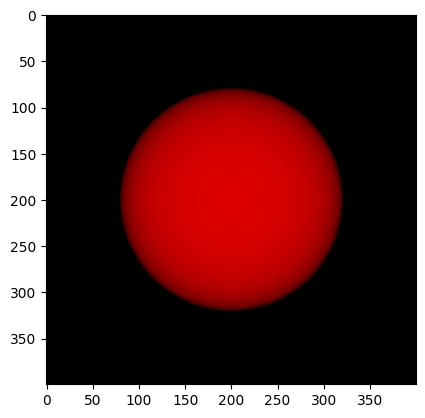

In [6]:
plt.imshow(img)
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

[0.04964102 0.         0.        ]


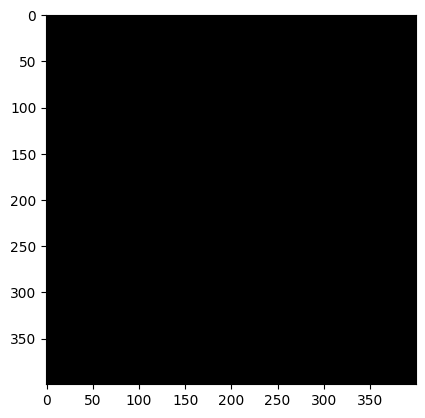

 10%|█         | 10/100 [00:07<01:10,  1.28it/s]

[0.4287393 0.        0.       ]


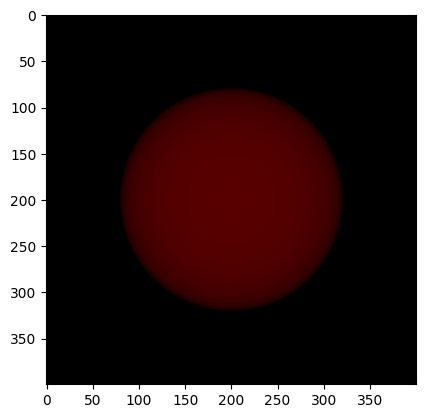

 20%|██        | 20/100 [00:15<01:03,  1.25it/s]

[0.6566131 0.        0.       ]


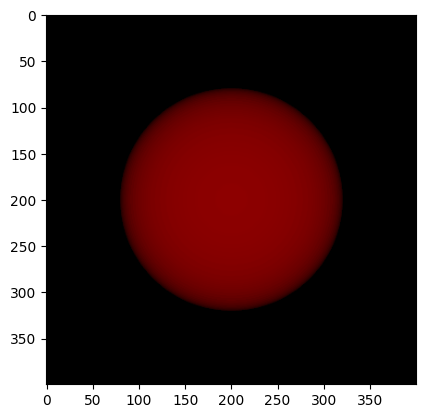

 30%|███       | 30/100 [00:23<00:53,  1.31it/s]

[0.79357314 0.         0.        ]


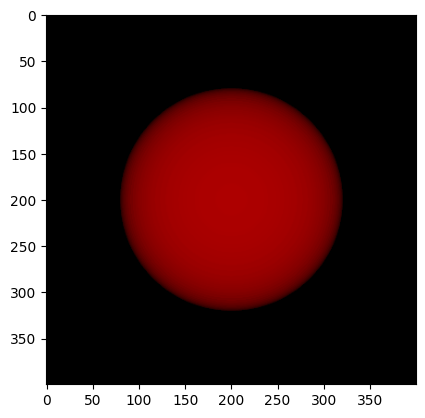

 40%|████      | 40/100 [00:31<00:47,  1.27it/s]

[0.87592345 0.         0.        ]


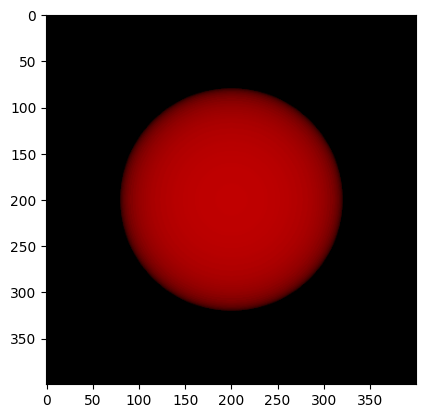

 50%|█████     | 50/100 [00:39<00:38,  1.31it/s]

[0.9254176 0.        0.       ]


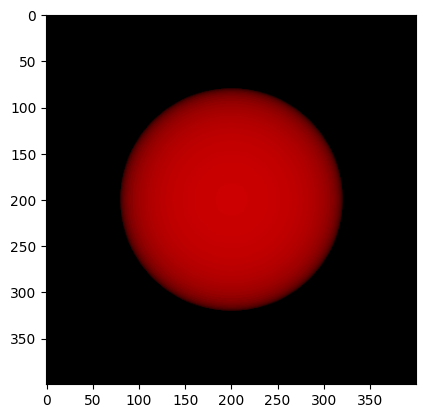

 60%|██████    | 60/100 [00:47<00:30,  1.30it/s]

[0.95516974 0.         0.        ]


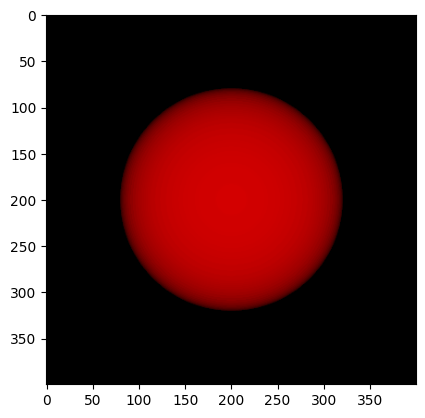

 70%|███████   | 70/100 [00:54<00:22,  1.33it/s]

[0.9730518 0.        0.       ]


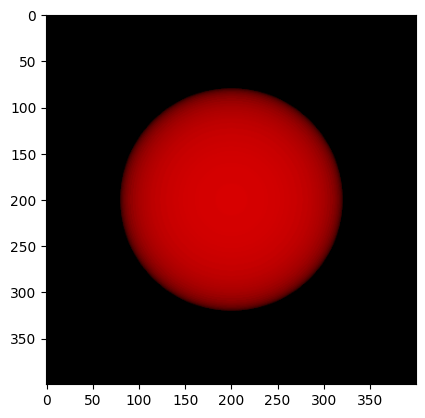

 80%|████████  | 80/100 [01:02<00:15,  1.30it/s]

[0.9838009 0.        0.       ]


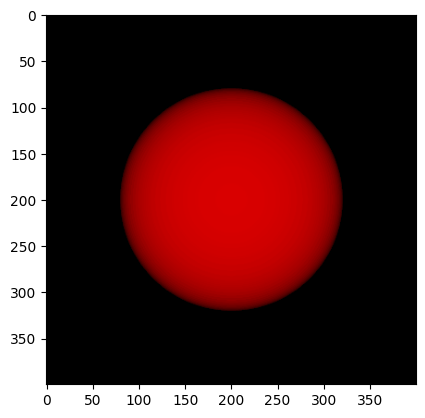

 90%|█████████ | 90/100 [01:11<00:08,  1.18it/s]

[0.99026257 0.         0.        ]


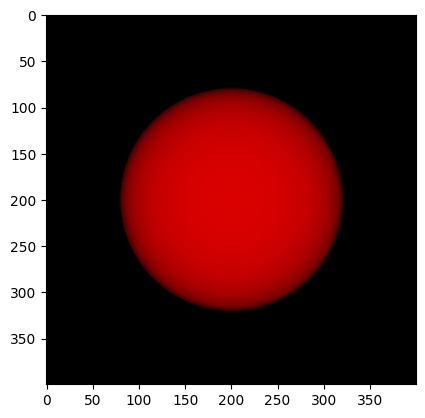

100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


In [7]:
c_to_optim = torch.tensor([0., 0., 0.], requires_grad=True)
optim = torch.optim.SGD({c_to_optim}, lr=5e-1)

for epoch in tqdm(range(100)):
    optim.zero_grad()
    model = Sphere(torch.tensor([0.,0.,-1.]), 
                0.1, 
                c_to_optim)
    Ax = rendering(model, torch.from_numpy(rays_o),
             torch.from_numpy(rays_d),
             0.8, 1.2)
    loss = ((Ax-c)**2).mean()
    loss.backward()
    optim.step()
    
    if epoch%10==0:
        print(c_to_optim.cpu().data.numpy())
        img = Ax.reshape(H,W,3).cpu().data.numpy()
        plt.imshow(img)
        plt.show()

[0.9938412 0.        0.       ]


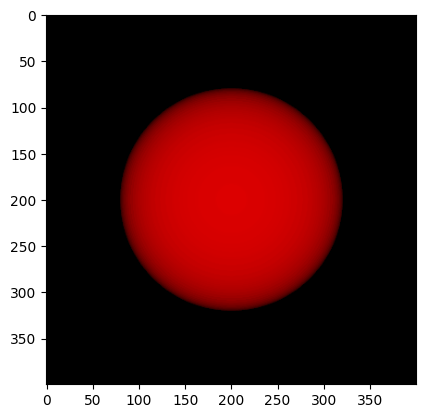

In [8]:
print(c_to_optim.cpu().data.numpy())
img = Ax.reshape(H,W,3).cpu().data.numpy()
plt.imshow(img)
plt.show()